In [1]:
from McSimulator import *
from XrayData import energyDict, attenuationLengthDict
from glob import glob
from ROOT import *

h_PixelEnergyDict = {}
h_ClusterEnergyDict = {}
h_CentralPixelEnergyDict = {}
h2_QcDict = {}
mc_h_PixelEnergyDict = {}
mc_h_ClusterEnergyDict = {}
mc_h_CentralPixelEnergyDict = {}
mc_h2_QcDict = {}

### Selections and histogram binning
selectionRange = 1 # keV
clusterBinningWidth = 0.05 #keV
### Number of threads for parallel processing
nThreads = 8

Welcome to JupyROOT 6.28/10


In [2]:
### Detector parameters
sensorThickness = 320 ### um, nominal thickness of the sensor from Hamamatsu
biasVoltage = 150 ### V, bias voltage of the sensor
voltageDrop = 0 ###
temperature = 273 + 20.0 + 14.8
if sensorThickness == 320:
    depletionVoltage = 29.6
elif sensorThickness == 650:
    depletionVoltage = 34.7
    
element = '25keV'
repulsionInvolved = True ### True if the repulsion effect is involved

In [3]:
### plot style

tsize = 29
style = TStyle("style", "style")
# Use plain black on white colors
icol = 0  # White
style.SetFrameBorderMode(icol)
style.SetFrameFillColor(icol)
style.SetCanvasBorderMode(icol)
style.SetCanvasColor(icol)
style.SetPadBorderMode(icol)
style.SetPadBorderSize(icol)
style.SetPadColor(icol)
style.SetStatColor(icol)

# Set the paper & margin sizes
style.SetPaperSize(20, 26)

# Set margin sizes
style.SetPadTopMargin(0.15)
style.SetPadRightMargin(0.15)
style.SetPadBottomMargin(0.15)
style.SetPadLeftMargin(0.15)

# Set title offsets (for axis labels)
style.SetTitleXOffset(1.)
style.SetTitleYOffset(1.4)

# Set font
font = 43  # Arial

style.SetTextFont(font)
style.SetTextSize(tsize)

style.SetLabelFont(font, "x")
style.SetTitleFont(font, "x")
style.SetLabelFont(font, "y")
style.SetTitleFont(font, "y")
style.SetLabelFont(font, "z")
style.SetTitleFont(font, "z")

style.SetLabelSize(tsize - 3, "x")
style.SetTitleSize(tsize, "x")
style.SetLabelSize(tsize - 3, "y")
style.SetTitleSize(tsize, "y")
style.SetLabelSize(tsize - 3, "z")
style.SetTitleSize(tsize, "z")

# Use bold lines and markers
style.SetMarkerStyle(20)
style.SetMarkerSize(0.5)
style.SetHistLineWidth(1)
style.SetLineStyleString(2, "[12 12]") # postscript dashes

# Get rid of error bar caps
style.SetEndErrorSize(0.)

# Do not display any of the standard histogram decorations
style.SetOptTitle(0)
style.SetOptStat(0)
style.SetOptFit(0)

# Put tick marks on top and RHS of plots
# style.SetPadTickX(1)
style.SetPadTickY(1)

# Remove legend borders and set font
style.SetLegendBorderSize(0)
style.SetLegendFillColor(0)
style.SetLegendFont(43)
style.SetLegendTextSize(tsize)

gROOT.SetStyle("style")
gROOT.ForceStyle()


In [4]:
### conduct charge transport simulation using simu1 method (CPU-based simplified simulation)
simuConfig = {
    'sensorThickness':sensorThickness,
    'T': temperature,
    'depletionVoltage': depletionVoltage,
    'appliedVoltage': biasVoltage - voltageDrop,
    'attenuationLength': attenuationLengthDict[element],
    'eIncident': energyDict[element],
    'repulsionInvolved': repulsionInvolved,
    'n': round(energyDict[element]/3.62),
    'nRepetetion': 10,
}
moench = McSimulator(simuConfig)
moench.nThread = nThreads ### specify the number of threads for the simulation
hv = simuConfig['appliedVoltage']
moench = McSimulator(simuConfig)
moench.zBinning = 128
zList = np.linspace(0, simuConfig['sensorThickness'], moench.zBinning+1)
z0List = (zList[:-1] + zList[1:]) / 2
moench.simulate()

from multiprocessing import Pool
with Pool(processes=nThreads) as pool:
    results = pool.map(moench.simulateOnce, z0List)

### Save the results: xs and ys
import os
if not os.path.exists('SimulationResults'):
    os.makedirs('SimulationResults')
for idxZ, result in enumerate(results):
    xs = result[2]
    ys = result[3]
    np.save(f'SimulationResults/{sensorThickness}um_{hv}V_xs_{element}_{idxZ}_of_{moench.zBinning}_simu1.npy', xs)
    np.save(f'SimulationResults/{sensorThickness}um_{hv}V_ys_{element}_{idxZ}_of_{moench.zBinning}_simu1.npy', ys)

No1: beta = 2.37, alpha = 11.66, rms = 7.67, time = 18.02, Chi2/NDF = 0.96
No2: beta = 2.42, alpha = 11.66, rms = 7.53, time = 17.85, Chi2/NDF = 1.26
No3: beta = 2.38, alpha = 11.57, rms = 7.71, time = 17.68, Chi2/NDF = 1.09
No4: beta = 2.37, alpha = 11.46, rms = 7.49, time = 17.51, Chi2/NDF = 1.15
No5: beta = 2.36, alpha = 11.43, rms = 7.49, time = 17.35, Chi2/NDF = 1.24
No6: beta = 2.42, alpha = 11.47, rms = 7.44, time = 17.18, Chi2/NDF = 1.18
No7: beta = 2.41, alpha = 11.42, rms = 7.56, time = 17.02, Chi2/NDF = 0.96
No8: beta = 2.33, alpha = 11.25, rms = 7.36, time = 16.85, Chi2/NDF = 1.08
No9: beta = 2.37, alpha = 11.25, rms = 7.35, time = 16.69, Chi2/NDF = 1.18
No10: beta = 2.36, alpha = 11.21, rms = 7.36, time = 16.52, Chi2/NDF = 1.17
No11: beta = 2.38, alpha = 11.24, rms = 7.50, time = 16.36, Chi2/NDF = 1.02
No12: beta = 2.37, alpha = 11.14, rms = 7.37, time = 16.20, Chi2/NDF = 1.01
No13: beta = 2.38, alpha = 11.10, rms = 7.34, time = 16.03, Chi2/NDF = 1.09
No14: beta = 2.38, al

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Info in <TCanvas::Print>: png file figures/No1.png has been created
Info in <TCanvas::Print>: png file figures/No2.png has been created
Info in <TCanvas::Print>: png file figures/No3.png has been created
Info in <TCanvas::Print>: png file figures/No4.png has been created
Info in <TCanvas::Print>: png file figures/No5.png has been created
Info in <TCanvas::Print>: png file figures/No6.png has been created
Info in <TCanvas::Print>: png file figures/No7.png has been created
Info in <TCanvas::Print>: png file figures/No8.png has been created
Info in <TCanvas::Print>: png file figures/No9.png has been created
Info in <TCanvas::Print>: png file figures/No10.png has been created
Info in <TCanvas::Print>: png file figures/No11.png has been created
Info in <TCanvas::Print>: png file figures/No12.png has been created
Info in <TCanvas::Print>: png file figures/No13.png has been created
Info in <TCanvas::Print>: png file figur

Processing 320um 150V 25keV simu1 with 128 bins
Alpha fitting chi2/NDF = 0.9620668179124168
Beta fitting chi2/NDF = 1.0675238881381268
3x3 cluster, CCE = 0.9999961339156839
 FCN=119.296 FROM MIGRAD    STATUS=CONVERGED      96 CALLS          97 TOTAL
                     EDM=5.5742e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.43134e+00   7.35933e-03   9.25437e-06   1.81821e-03
   2  p1           2.57668e+00   1.23158e-02   4.25223e-06  -2.52112e-03
   3  p2          -7.42044e-02   4.74858e-03   1.33401e-06  -1.98981e-02
   4  p3           7.38696e-04   1.39767e-04   9.64386e-08  -3.96290e-01
 FCN=131.305 FROM MIGRAD    STATUS=CONVERGED     233 CALLS         234 TOTAL
                     EDM=2.25717e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO. 

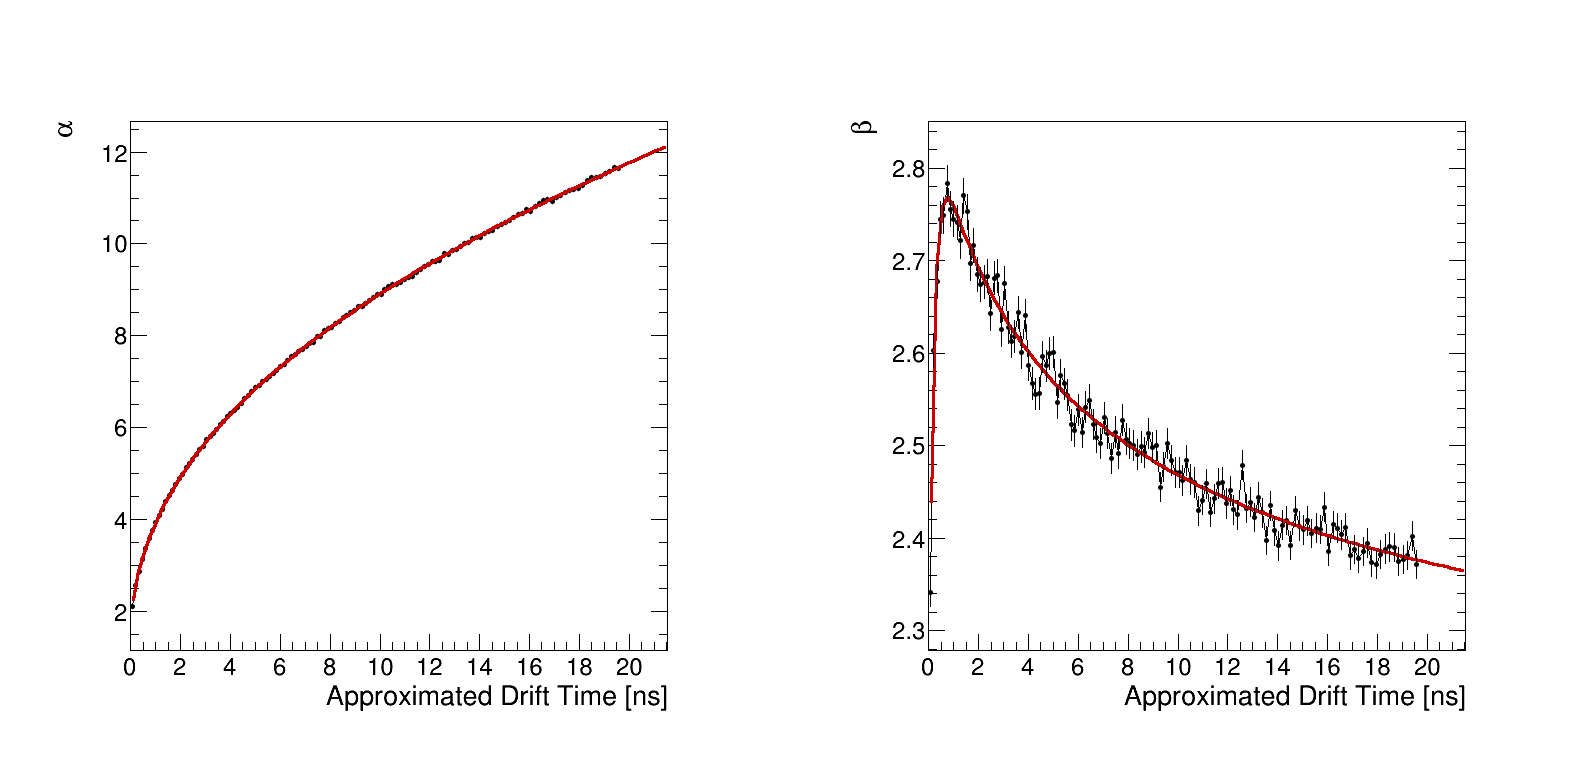

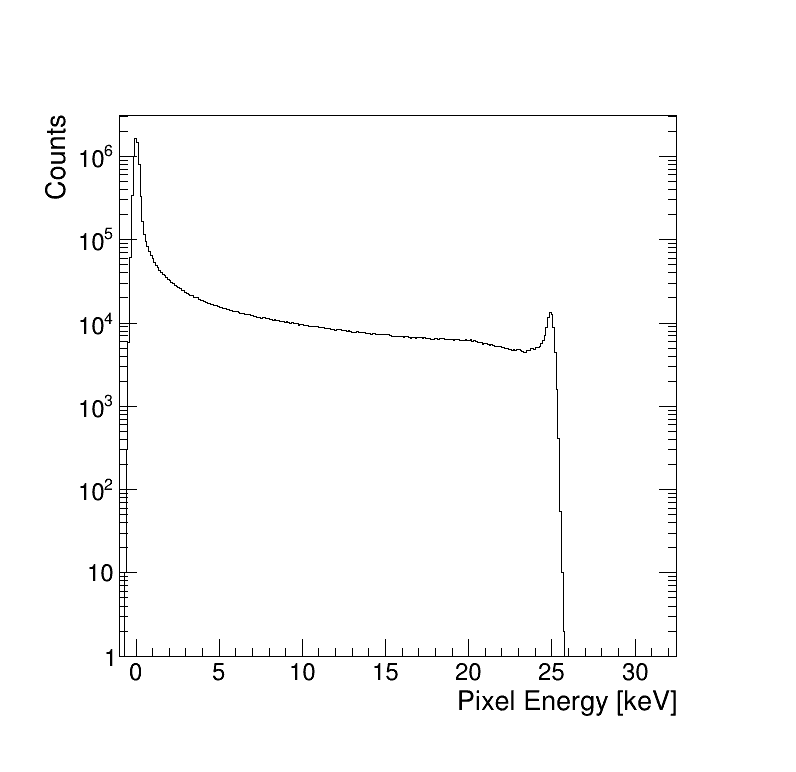

In [5]:
### simulation massive generation, first parameterization then sampling
import McUsefulFunctions
import imp
imp.reload(McUsefulFunctions)
config = (element, repulsionInvolved) ### element, repulsionInvolved

mcConfig = {
    'sensorCode': f'{sensorThickness}um',
    'energy': energyDict[element], ### eV
    'nTotalIncident': 1000000,
    'clusterWidth': 3, ### pixel
    'pixelSize': 25, ### um
    'Roi': [0, 400, 0, 400],
    'noiseEneFrame': np.ones((400, 400)) * 0.1276 * 1000, ### eV
    'shotNoiseFactor': 0.0,
    'calibrationNoise': 0.0,
    'selectionRange': selectionRange, ### keV
    'nThread': nThreads,
    'sensorThickness': sensorThickness,
    'T': temperature,
    'zBins': 128,
    'hv': biasVoltage - voltageDrop,
    'depletionVoltage': depletionVoltage,
    'attenuationLength': attenuationLengthDict[element],
    'element': element,
    'resultsPath': 'SimulationResults',
    'simulationMethod': 'simu1', ### 'simu1' (cpu) or 'simu2' (gpu)
}
McUsefulFunctions.init(mcConfig)
c0 = McUsefulFunctions.parameterization()
c0.Draw()
McUsefulFunctions.process_fromParameters()
mc_h_PixelEnergyDict[config] = McUsefulFunctions.h1_PixelEnergy.Clone()
c = TCanvas('c', 'c', 800, 800)
c.SetLogy()
mc_h_PixelEnergyDict[config].Draw()
c.Draw()

In [6]:
measurementsFile = TFile('Measurements.root', 'UPDATE')
measurementsFile.ls()
measurementsFile.Close()

TFile**		Measurements.root	
 TFile*		Measurements.root	
  KEY: TH1D	PixelEnergy_15keV_650um_150V;1	PixelEnergy_15keV_650um_150V
  KEY: TH1D	PixelEnergy_20keV_650um_150V;1	PixelEnergy_20keV_650um_150V
  KEY: TH1D	PixelEnergy_25keV_650um_150V;1	PixelEnergy_25keV_650um_150V
  KEY: TH1D	PixelEnergy_25keV_320um_90V;1	PixelEnergy_25keV_320um_90V
  KEY: TH1D	PixelEnergy_25keV_320um_150V;1	PixelEnergy_25keV_320um_150V
  KEY: TH1D	PixelEnergy_15keV_320um_150V;1	PixelEnergy_15keV_320um_150V


element: 25keV, bias voltage: 150V, repulsion involved: True
Simu Pixel Noise: 0.134 [keV], center: 0.015 [keV]
Meas Pixel Noise: 0.143 [keV], center: 0.017 [keV]
Simu average Pixel Energy: 2.778
Meas average Pixel Energy: 2.787
Average Chi2 = 12.910 from 1 to 25.00 keV, nDof = 96
Average abs relative diff = 2.341% from 1 to 25.00 keV


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 62 points have been skipped


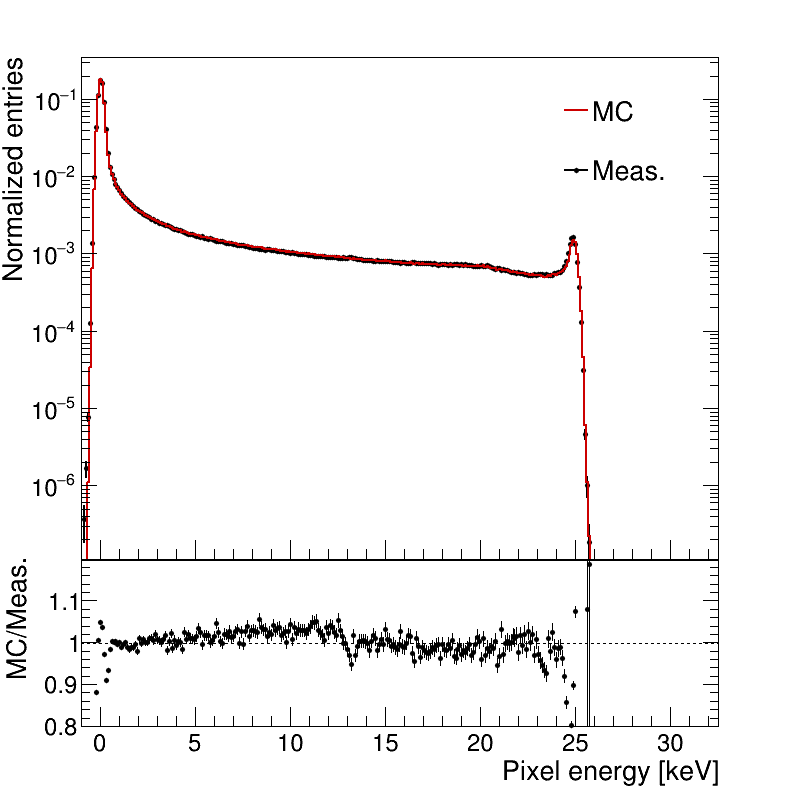

In [7]:
### plotting ###
print(f'element: {element}, bias voltage: {biasVoltage}V, repulsion involved: {repulsionInvolved}')
measurementsFile = TFile('Measurements.root')
h_PixelEnergy = measurementsFile.Get(f'PixelEnergy_{element}_{sensorThickness}um_{biasVoltage}V')
h_PixelEnergy.SetDirectory(0)
measurementsFile.Close()
_c = TCanvas('c', 'c')
_c.SetCanvasSize(800, 800)
_c.SetLogy(1)
mc_h_PixelEnergyDict[config].Scale(1/mc_h_PixelEnergyDict[config].Integral())
mc_h_PixelEnergyDict[config].SetLineWidth(2)
mc_h_PixelEnergyDict[config].Fit("gaus", 'Q', '', -0.5, 0.1)
mc_h_PixelEnergyDict[config].GetFunction("gaus").SetLineWidth(0)
mc_h_PixelEnergyDict[config].SetTitle(f"{element};Pixel energy [keV];Normalized entries")
mc_h_PixelEnergyDict[config].GetYaxis().SetTitleOffset(1.5)
mc_h_PixelEnergyDict[config].SetLineColor(kRed+1)
h_PixelEnergy.SetLineColor(kBlack)
h_PixelEnergy.SetLineWidth(2)
h_PixelEnergy.Scale(1/h_PixelEnergy.Integral())
h_PixelEnergy.Fit("gaus", 'Q', '', -0.5, 0.1)
h_PixelEnergy.GetFunction("gaus").SetLineColor(kBlack)
h_PixelEnergy.GetFunction("gaus").SetLineWidth(0)

print(f'Simu Pixel Noise: {mc_h_PixelEnergyDict[config].GetFunction("gaus").GetParameter(2):.3f} [keV], center: {mc_h_PixelEnergyDict[config].GetFunction("gaus").GetParameter(1):.3f} [keV]')
print(f'Meas Pixel Noise: {h_PixelEnergy.GetFunction("gaus").GetParameter(2):.3f} [keV], center: {h_PixelEnergy.GetFunction("gaus").GetParameter(1):.3f} [keV]')
print(f'Simu average Pixel Energy: {mc_h_PixelEnergyDict[config].GetMean():.3f}')
print(f'Meas average Pixel Energy: {h_PixelEnergy.GetMean():.3f}')

rp_PixelEnergy = TRatioPlot(mc_h_PixelEnergyDict[config], h_PixelEnergy)
rp_PixelEnergy.Draw()
rp_PixelEnergy.GetLowerRefYaxis().SetTitle("MC/Meas.")
rp_PixelEnergy.GetLowerRefYaxis().SetRangeUser(0.8, 1.2)
rp_PixelEnergy.SetUpBottomMargin(0.)
rp_PixelEnergy.SetLowTopMargin(0.)
sumChi2 = 0
subAbsRelDiff = 0
nBins = 0
for i in range(1, h_PixelEnergy.GetNbinsX()+1):
    if h_PixelEnergy.GetBinCenter(i) < 1:
        continue ### ignore the low energy part
    if h_PixelEnergy.GetBinCenter(i) > energyDict[element]/1000:
        break
    if mc_h_PixelEnergyDict[config].GetBinContent(i) > 1e-3:
        if h_PixelEnergy.GetBinContent(i) < 1e-3:
            continue
        _error2 = h_PixelEnergy.GetBinError(i)**2 + mc_h_PixelEnergyDict[config].GetBinError(i)**2
        _chi2 = (mc_h_PixelEnergyDict[config].GetBinContent(i) - h_PixelEnergy.GetBinContent(i))**2 / _error2
        sumChi2 += _chi2
        subAbsRelDiff += abs(mc_h_PixelEnergyDict[config].GetBinContent(i) - h_PixelEnergy.GetBinContent(i)) / h_PixelEnergy.GetBinContent(i) * 100
        nBins += 1
nDof = nBins - 1
print(f'Average Chi2 = {sumChi2/nDof:.3f} from 1 to {energyDict[element]/1000:.2f} keV, nDof = {nDof}')
print(f'Average abs relative diff = {subAbsRelDiff/nBins:.3f}% from 1 to {energyDict[element]/1000:.2f} keV')
l = TLegend(0.7, 0.75, 0.86, 0.90)
l.AddEntry(mc_h_PixelEnergyDict[config], "MC", 'l')
l.AddEntry(h_PixelEnergy, "Meas.", 'lp')
l.Draw('SAME')
rp_PixelEnergy.GetLowYaxis().SetNdivisions(505)
rp_PixelEnergy.GetUpperPad().cd()
mc_h_PixelEnergyDict[config].Draw('same hist')
_c.Draw()